In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

import simon_64_128
import simon_64_128_simulation

from helper import KeyHypothesis
import helper
import correlations

from measurement import Measurements, Measurement

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [55]:
# project = cw.import_project("./traces/07_simon_plain_50000/trace.zip", overwrite=True)
# project = cw.import_project("./traces/10_simon_masked_50000/trace.zip", overwrite=True)
project = cw.import_project("./traces/temp/trace.zip", overwrite=True)

In [56]:
TOTAL_NUM_MEASUREMENTS = len(project.traces)
TOTAL_VALS_PER_MEASUREMENT = len(project.traces[0].wave)

CORR_DIFF_THRESHOLD = 0.02

NUM_MEASUREMENTS = 2000
VALS_PER_MEASUREMENT = 1000

# Transform Trace Project into Measurement object

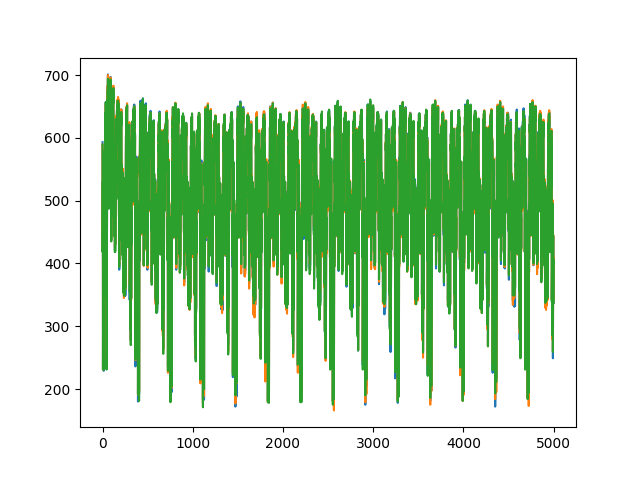

In [57]:
%matplotlib widget

plaintexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers = np.zeros((TOTAL_NUM_MEASUREMENTS, TOTAL_VALS_PER_MEASUREMENT), dtype=np.uint32)

for i, trace in enumerate(project.traces):

    pt = trace.textin
    ct = trace.textout

    plaintexts[i,0] = pt[0] << 24 | pt[1] << 16 | pt[2] << 8 | pt[3]
    plaintexts[i,1] = pt[4] << 24 | pt[5] << 16 | pt[6] << 8 | pt[7]

    ciphertexts[i,0] = ct[0] << 24 | ct[1] << 16 | ct[2] << 8 | ct[3]
    ciphertexts[i,1] = ct[4] << 24 | ct[5] << 16 | ct[6] << 8 | ct[7]
    powers[i,:] = trace.wave

all_measurements = Measurements(plaintexts, ciphertexts, powers)
measurements = Measurements(plaintexts[0:NUM_MEASUREMENTS], ciphertexts[0:NUM_MEASUREMENTS], powers[0:NUM_MEASUREMENTS, 0:VALS_PER_MEASUREMENT])

plt.figure()

plt.plot(all_measurements[0].power)
plt.plot(all_measurements[1].power)
plt.plot(all_measurements[2].power)
plt.show()


In [59]:
# key = np.array([0x19013660, 0x86de7696, 0xd0427aff, 0x738dd98a], dtype=np.uint32)
# key = np.array([0x1B1A1918, 0x13121110, 0x0B0A0908, 0x03020100], dtype=np.uint32)
# key = np.array([0x8dcc04b1, 0xad004534, 0x8afa7151, 0xf173d6d7], dtype=np.uint32) # measurement 07_simon_plain_50000
# key = np.array([0xb057096b, 0x07872546, 0xae7fe580, 0x5fbc809f], dtype=np.uint32) # measurement 10_simon_masked_50000
# key = np.array([0xbae7cfb7, 0xb9285666, 0x70c74f9c, 0x146c0f4c], dtype=np.uint32) # measurement 11_simon_masked_50000
key = np.array([0x4f841273, 0xe61edffd, 0xc5c5c70e, 0xe90722f5], dtype=np.uint32) # temp measurement

pt = measurements[0].plaintext
ct = measurements[0].ciphertext

ct_expect, _ = simon_64_128.encrypt_block(pt, key)

print(ct)
print(ct_expect)

[4162528103 4243549010]
[4162528103 4243549010]


In [60]:
print(all_measurements.plaintext.shape)
print(all_measurements.ciphertext.shape)
print(all_measurements.power.shape)

print(measurements.plaintext.shape)
print(measurements.ciphertext.shape)
print(measurements.power.shape)

(2000, 2)
(2000, 2)
(2000, 5000)
(2000, 2)
(2000, 2)
(2000, 1000)


# Attack

In [61]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

promising_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    sub_hypos: list[KeyHypothesis] = []

    for h in promising_hypos:
        sub_hypos.extend(h.get_sub_hypos())

    print(f"Find correlations for {len(sub_hypos)} hypotheses.")

    helper.calc_corrs_for_hypos(sub_hypos, measurements)
    promising_hypos = helper.filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)
    
    print(f"Found {len(promising_hypos)} promising hypotheses.")
    for hypo in promising_hypos:
        
        print(f"{helper.array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            print(f"Extracted Key: {helper.array_to_hex_str(extracted_key)}")
            break
else:
    print("Could not determine key")

Perform Attack Step 1/16
Find correlations for 256 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x0000000A: correlation: 0.3654964668740345
0x00000000 0x00000000 0x00000000 0x000000F5: correlation: -0.36549646687403436
Perform Attack Step 2/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x0000DD0A: correlation: 0.5597536341359473
0x00000000 0x00000000 0x00000000 0x000022F5: correlation: -0.5597536341359473
Perform Attack Step 3/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00F8DD0A: correlation: 0.7178004782446371
0x00000000 0x00000000 0x00000000 0x000722F5: correlation: -0.7178004782446373
Perform Attack Step 4/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x16F8DD0A: correlation: 0.8502712938240721
0x00000000 0x00000000 0x00000000 0xE90722F5: correlation: -0.8502712938240718
Perform

KeyboardInterrupt: 

# Attack Insights

(256, 5000)


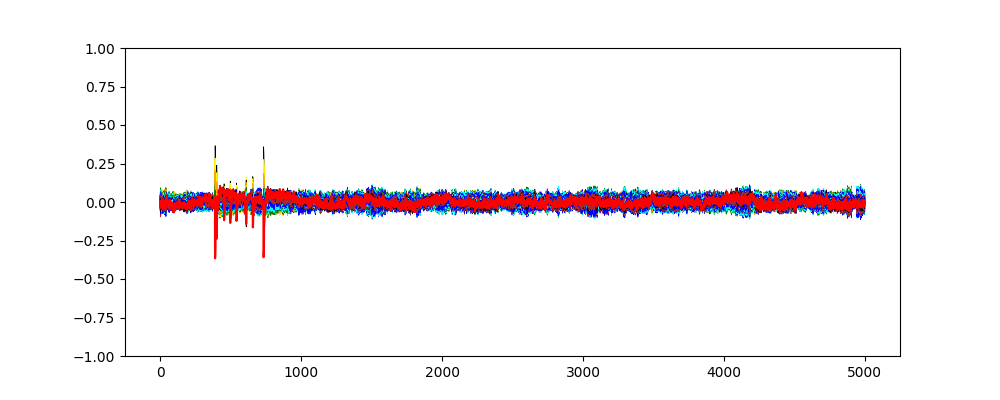

In [62]:
guessed_keys = np.zeros((256,4), dtype=np.uint32)
guessed_keys[:, 3] = np.arange(256)


expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        all_measurements.plaintext,
        guessed_keys, 
        0, 
        np.uint32(0xFF)
)

corrs = correlations.calc_corrs(expected_hws, all_measurements.power)
print(corrs.shape)

colors = ["red", "black", "brown", "blue", "cyan", "green", "orange", "yellow", "black"]
correct_byte = int(key[3] & 0xFF)

plt.figure(figsize=(10,4))
for i in range(256):
    color_idx = int.bit_count(i ^ correct_byte)
    color = colors[color_idx]
    # color = "black"

    plt.plot(corrs[i], color=color, linewidth=0.5)

plt.plot(corrs[correct_byte], color="red")

plt.ylim(-1, 1)
plt.show()

In [63]:
%matplotlib widget
guessed_keys = np.zeros((256,4), dtype=np.uint32)
guessed_keys[:, 3] = np.arange(256)

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        all_measurements.plaintext,
        guessed_keys, 
        0, 
        np.uint32(0xFF)
)
print(expected_hws.shape)

corrs = correlations.Corr((256,TOTAL_VALS_PER_MEASUREMENT))

di = 50
best_corrs_over_num_measurements = np.zeros((256,TOTAL_NUM_MEASUREMENTS//di), dtype=np.float64)

n = 10
for i in range(0,TOTAL_NUM_MEASUREMENTS, n):
    corrs.update(expected_hws[i:i+n,:], all_measurements.power[i:i+n,:]) 
    if i % di == 0:
        idx = i // di
        best_corrs_over_num_measurements[:, idx] = corrs.max(axis=1)


(2000, 256)


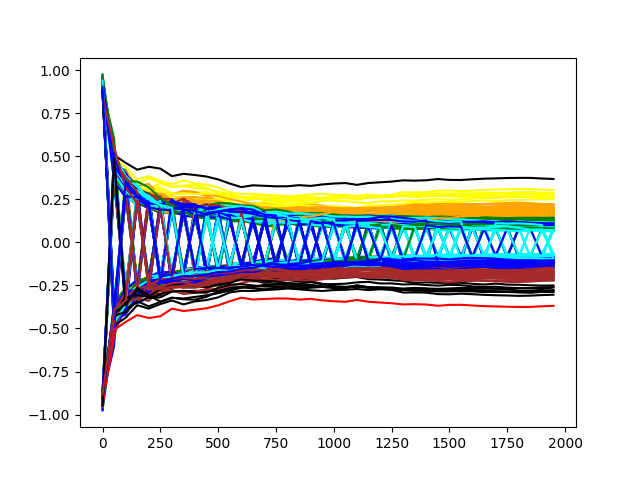

In [64]:
%matplotlib widget

plt.figure()
x = np.arange(0, TOTAL_NUM_MEASUREMENTS, step=di)

colors = ["red", "black", "brown", "blue", "cyan", "green", "orange", "yellow", "black"]
correct_byte = int(key[3] & 0xFF)

for i in range(256):
    color_idx = int.bit_count(i ^ correct_byte)
    color = colors[color_idx]
    plt.plot(x, best_corrs_over_num_measurements[i], color=color)

plt.show()